# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 70.8 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-55b00cfb-a748-2d75-b2e2-52eb9c8b4ef5)


In [ ]:
# before starting, we define some constants
NUM_SAMPLES = 200

FIGSIZE = (9, 6)
LOWEST_Q, LOW_Q, HIGH_Q, HIGHEST_Q = 0.01, 0.1, 0.9, 0.99
LABEL_Q_OUTER = f"{int(LOWEST_Q * 100)}-{int(HIGHEST_Q * 100)}th percentiles"
LABEL_Q_INNER = f"{int(LOW_Q * 100)}-{int(HIGH_Q * 100)}th percentiles"

## Model Selection




## Feature Engineering



In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Forcasting based on Energy Charts datasets/Energy_Charts_2025_to_2024.csv"

df = (
    pd.read_csv(path, low_memory=False)
      .fillna(0)
      .query("`Date (GMT+1)` == `Date (GMT+1)`")
)

# 1) Robust parsen
df['Date (GMT+1)'] = pd.to_datetime(
    df['Date (GMT+1)'],
    errors='coerce',
    infer_datetime_format=True
)

df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], errors='coerce')
df = df.dropna(subset=['Date (GMT+1)'])

# Duplikate entfernen (behalte die erste Zeile)
df = df.drop_duplicates(subset=['Date (GMT+1)'], keep='first')

df = df.set_index('Date (GMT+1)')
print(df.index.dtype)








Mounted at /content/drive
datetime64[ns, UTC+01:00]


In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

#96 Tag
#672 Woche
#1344 2Wochen
#2688 Monat
#16128 6Monate
#32256 Jahr
#64512 2Jahre




#forecast_horizon_price = 672
forecast_horizon_price = 12         # 3 Stunden Forecast (12 * 15min)

df["time"] = df.index

# COVARIATES als Darts TimeSeries
series_price = TimeSeries.from_dataframe(
    df,
    time_col="time",
    value_cols="Day Ahead Auction (DE-LU)",
    fill_missing_dates=True,
    freq="15T"
)

covariates_renewload = TimeSeries.from_dataframe(
    df,
    time_col="time",
    value_cols="Renewable share of load",
    fill_missing_dates=True,
    freq="15T"
)


training_cutoff_price = series_price.time_index[-(2 * forecast_horizon_price)]

train_price, val_price = series_price.split_before(training_cutoff_price)

transformer_price = Scaler()
train_price_transformed = transformer_price.fit_transform(train_price)
val_price_transformed = transformer_price.transform(val_price)
series_price_transformed = transformer_price.transform(series_price)


cov_renewload_train, cov_renewload_val = covariates_renewload.split_before(training_cutoff_price)

transformer_renewload = Scaler()
transformer_renewload.fit(cov_renewload_train)
covariates_renewload_transformed = transformer_renewload.transform(covariates_renewload)


In [ ]:
# Check the end times of the series
print(f"Train end time: {train_price.end_time()}")
print(f"Validation end time: {val_price.end_time()}")

Train end time: 2025-12-31 17:45:00
Validation end time: 2025-12-31 23:45:00


In [ ]:


input_chunk_length_price = 672      # 1 week

my_model_price = TFTModel(
    input_chunk_length=336,        # halbe Woche
    output_chunk_length=forecast_horizon_price,
    hidden_size=16,
    lstm_layers=1,
    batch_size=32,
    n_epochs=50,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)



my_model_price.fit(
    train_price_transformed,
    past_covariates=covariates_renewload_transformed,
    verbose=True
)



Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, skip_interpolation=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=336, output_chunk_length=12, batch_size=32, n_epochs=50, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

## Hyperparameter Tuning




## Implementation




## Evaluation Metrics

We evaluate the model using R², MSE, RMSE, and MAE. These metrics capture different aspects of forecasting performance:




In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=NUM_SAMPLES)

    # plot actual series
    plt.figure(figsize=FIGSIZE)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=LOWEST_Q, high_quantile=HIGHEST_Q, label=LABEL_Q_OUTER
    )
    pred_series.plot(low_quantile=LOW_Q, high_quantile=HIGH_Q, label=LABEL_Q_INNER)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

Predicting: |          | 0/? [00:00<?, ?it/s]

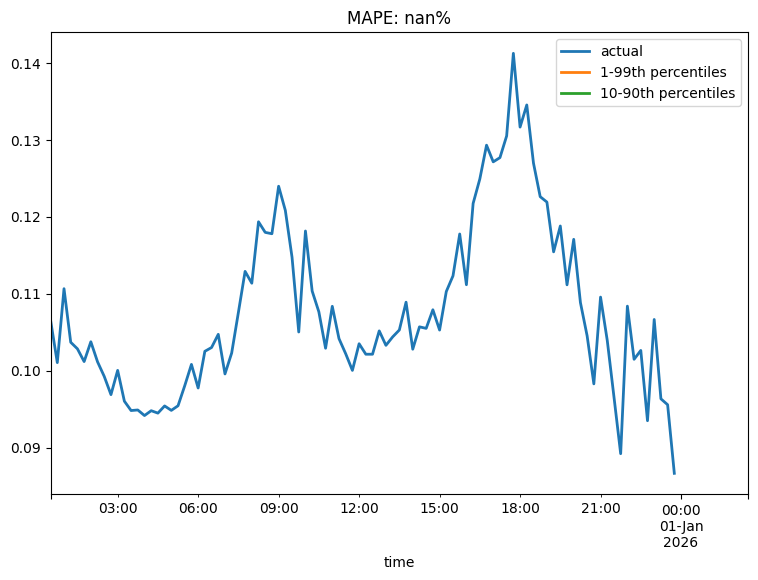

In [ ]:
# evaluate the model
n = 35
eval_model(
    model=my_model_price,
    n=n,
    actual_series=series_price_transformed[
        train_price.end_time() - (2 * n - 1) * train_price.freq :
    ],
    val_series=val_price_transformed,
)

## Comparative Analysis

The LSTM achieves the best performance overall, with an R² of 0.88 and significantly lower errors than both SARIMAX and XGBoost. Its MSE (331) and RMSE (18.19) show that it captures the temporal patterns in the data far more effectively, making it the strongest forecasting model in this comparison.

XGBoost  
MSE: 1358.9230238188288  
RMSE: 36.86357312875176   

Baseline Model (SARIMAX)  
MSE: 1424.2550828672138    
RMSE: 37.7393042181121  

LSTM_GRU  
R²: 0.8836387915795975  
MSE: 331.0454052959218  
RMSE: 18.194653206256003  
MAE: 13.079722743312484  

N-Beats  
R²: -0.3709542751312256  
MSE: 3900.338623046875  
RMSE: 62.45269107930318  
MAE: 52.551902770996094  


In [ ]:
# Compute the backtest predictions
last_points_only = False
backtest_series_price = my_model_price.historical_forecasts(
    series_price_transformed,
    num_samples=NUM_SAMPLES,
    start=training_cutoff_price,
    forecast_horizon=forecast_horizon_price,
    stride=1 if last_points_only else forecast_horizon_price,
    retrain=False,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)

backtest_series_price = (
    concatenate(backtest_series_price)
    if isinstance(backtest_series_price, list)
    else backtest_series_price
)

Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries: 100%|██████████| 3/3 [00:00<00:00, 3275.95it/s]


In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=FIGSIZE)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=LOWEST_Q, high_quantile=HIGHEST_Q, label=LABEL_Q_OUTER
    )
    backtest_series.plot(low_quantile=LOW_Q, high_quantile=HIGH_Q, label=LABEL_Q_INNER)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

MAPE: nan%


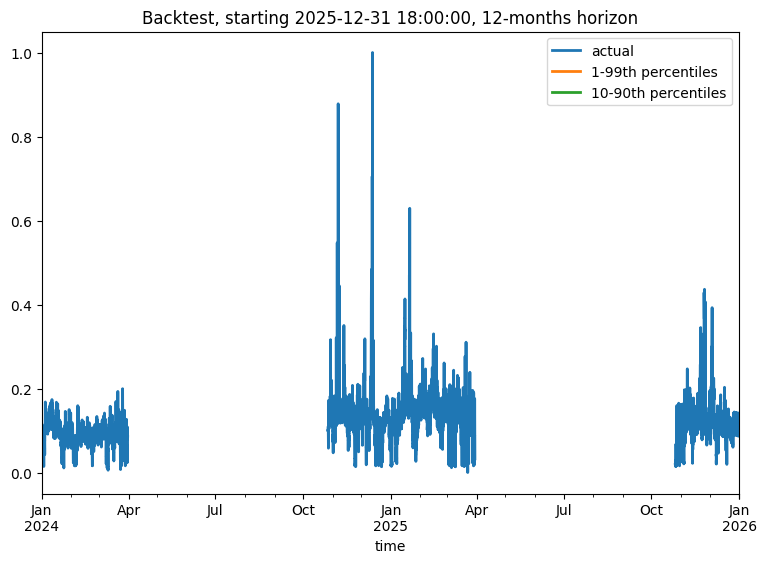

In [ ]:
eval_backtest(
    backtest_series=backtest_series_price,
    actual_series=series_price_transformed[
        train_price.start_time() - 2 * forecast_horizon_price * train_price.freq :
    ],
    horizon=forecast_horizon_price,
    start=training_cutoff_price,
    transformer=transformer_price,
)

In [ ]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(my_model_price)
explainability_result = explainer.explain()

Predicting: |          | 0/? [00:00<?, ?it/s]

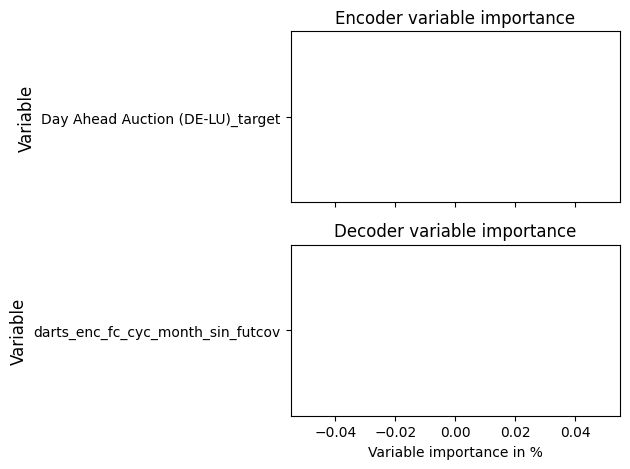

In [ ]:
explainer.plot_variable_selection(explainability_result)

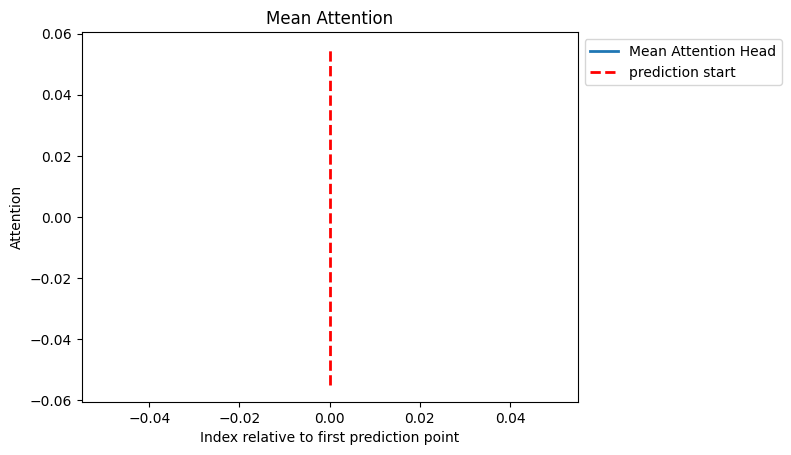

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [ ]:
explainer.plot_attention(explainability_result, plot_type="time")

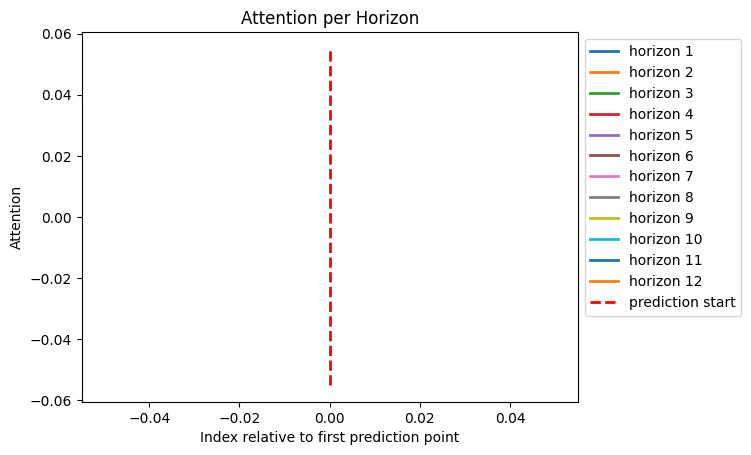

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [ ]:

explainer.plot_attention(explainability_result, plot_type="all")